In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import time
from IPython.display import clear_output

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
from zipfile import ZipFile
dataset = '/content/drive/MyDrive/4th Year/gan-getting-started.zip'

with ZipFile(dataset, 'r') as zpr:
    zpr.extractall()
    print('Na-extract na Lods')

Na-extract na Lods


In [7]:
class dataset_pipeline():
    def __init__(self) -> None:
        self.image_feature_description = {
            'image_name': tf.io.FixedLenFeature([], tf.string),
            'image': tf.io.FixedLenFeature([], tf.string),
            'target' : tf.io.FixedLenFeature([], tf.string)
        }
        self.IMAGE_SIZE= [256,256]
        self.IMG_HEIGHT = 256
        self.IMG_WIDTH = 256

    def decode_image(self, image):
        """Decoding image from tf.string form representation from tfrecord"""
        image = tf.image.decode_jpeg(image, channels=3)
        image = (tf.cast(image, tf.float32)/127.5) -1
        image = tf.reshape(image, [*self.IMAGE_SIZE,3])
        return image
    
    def random_augment(self, image):
        image = tf.image.resize(image, [286,286], method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        image = tf.image.random_crop(image, size=[self.IMG_HEIGHT, self.IMG_WIDTH,3])
        image = tf.image.random_flip_left_right(image)
        return image
    
    def parse_image(self, example):        
        parsed_example = tf.io.parse_single_example(example, self.image_feature_description)
        image = self.decode_image(parsed_example["image"])
        image = self.random_augment(image)
        return image

    def get_paths(self, directory_path):
        """directory_path : path to the directory containing all tfrecords
        returns the list of all tfrecords"""
        path_list = []
        for path in os.listdir(directory_path):
            path_list.append(os.path.join(directory_path, path))
        return path_list

    def load_tfrecord_dataset(self, directory_path):
        """directory_path : list of paths of all tfrecords."""
        paths =  self.get_paths(directory_path)
        dataset = tf.data.TFRecordDataset(paths)
        dataset = dataset.map(self.parse_image, num_parallel_calls= tf.data.AUTOTUNE)
        dataset = dataset.map(self.random_augment, num_parallel_calls= tf.data.AUTOTUNE)
        return dataset

    def plot_sample(self, dataset):
        sample= next(iter(dataset))
        plt.imshow(sample[0]*0.5+0.3)
        plt.axis('off')
        plt.show()

In [8]:
monet_tf = 'monet_tfrec'
photo_tf = 'photo_tfrec'

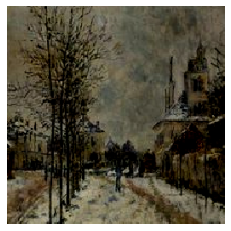

In [9]:
data_pipe = dataset_pipeline()
MONET_DS = data_pipe.load_tfrecord_dataset(monet_tf).batch(8)
data_pipe.plot_sample(MONET_DS)

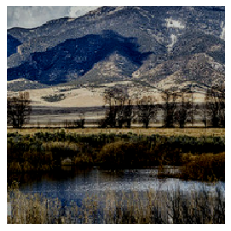

In [10]:
PHOTO_DS = data_pipe.load_tfrecord_dataset(photo_tf).batch(10)
data_pipe.plot_sample(PHOTO_DS)

In [11]:
class InstanceNormalization(layers.Layer):
    """Instance Normalization layer"""
    def __init__(self, epsilon= 1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon= epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(name= 'scale', shape= input_shape[-1:], initializer= tf.random_normal_initializer(1, 0.02), trainable= True)
        self.offset = self.add_weight(name='offset', shape= input_shape[-1:], initializer= 'zeros', trainable= True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1,2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized= (x-mean)*inv
        return self.scale*normalized + self.offset

In [12]:
class Model:

    def __init__(self, output_channels=3):                     
        self.cross_entropy_loss = keras.losses.BinaryCrossentropy(from_logits=True)

        self.OUTPUT_CHANNELS= output_channels
        self.LAMBDA = 30

        self.generator_g = self.Generator()
        self.generator_f = self.Generator()

        self.discriminator_x = self.Discriminator(target= False)
        self.discriminator_y = self.Discriminator(target= False)

        self.generator_g_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.generator_f_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.discriminator_x_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.discriminator_y_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
        

    def upsample(self, filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', 
                                          kernel_initializer= initializer, use_bias= False))

        if apply_dropout:            
            result.add(layers.Dropout(0.5))

        result.add(layers.LeakyReLU())
        return result


    def downsample(self, filters, size, apply_norm = True):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer= initializer, use_bias= False))

        if apply_norm:
            result.add(InstanceNormalization())
        result.add(layers.LeakyReLU())
        return result

    def discriminator_loss(self, real, generated):
        real_loss = self.cross_entropy_loss(tf.ones_like(real), real)
        gen_loss = self.cross_entropy_loss(tf.zeros_like(generated), generated)
        total_loss = real_loss + gen_loss
        return total_loss*0.5
    
    def generator_loss(self, preds_generated):  		
        return self.cross_entropy_loss(tf.ones_like(preds_generated), preds_generated)
    
    def cycle_loss(self, real_image, cycled_image):
        loss = tf.reduce_mean(tf.abs(real_image-cycled_image))
        return loss*self.LAMBDA

    def identity_loss(self, real_image, same_image):

        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return loss*self.LAMBDA*0.5


    def Generator(self):

        down_stack=[
          self.downsample(64,4, apply_norm=False),
          self.downsample(128,4),
          self.downsample(256,4),
          self.downsample(512,4),
          self.downsample(512,4),
          self.downsample(512,4),
          self.downsample(512,4),
          self.downsample(512,4),
          ]

        up_stack = [
          self.upsample(512, 4, apply_dropout=True),
          self.upsample(512, 4, apply_dropout=True),
          self.upsample(512, 4, apply_dropout=True),
          self.upsample(512, 4),
          self.upsample(256, 4),
          self.upsample(128, 4),
          self.upsample(64, 4),
          ]
        
        initializer = tf.random_normal_initializer(0., 0.02)
        last = layers.Conv2DTranspose(self.OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer= initializer, activation= 'tanh')

        concat = layers.Concatenate()
        inputs= layers.Input(shape=[None, None, 3])

        x= inputs

        skips= []

        for down in down_stack:            
            x = down(x)
            skips.append(x)
        
        skips = reversed(skips[:-1])

        for up,skip in zip(up_stack, skips):
            x= up(x)
            x= concat([x, skip])

        x= last(x)
        return keras.Model(inputs= inputs, outputs= x)

    def Discriminator(self, target=True):

        initializer = tf.random_normal_initializer(0., 0.02)
        inp= layers.Input(shape=[None, None, 3], name='input_image')
        x= inp

        if target:            
            tar = layers.Input(shape=[None, None, 3], name='target_image')
            x = layers.Concatenate([inp,tar])

        down1= self.downsample(64,4, apply_norm=False)(x)
        down2= self.downsample(128,4)(down1)
        down3= self.downsample(256, 4)(down2)

        zero_pad1= layers.ZeroPadding2D()(down3)
        conv= layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
        norm1= InstanceNormalization()(conv)
        leaky_relu= layers.LeakyReLU()(norm1)
        zero_pad2= layers.ZeroPadding2D()(leaky_relu)
        last = layers.Conv2D(1, 4, strides= 1, kernel_initializer=initializer)(zero_pad2)

        if target:
            return keras.Model(inputs= [inp, last], outputs= last)
        else:            
            return keras.Model(inputs= inp, outputs= last)

        
    @tf.function
    def train_step(self, real_x, real_y):


        with tf.GradientTape(persistent=True) as tape:
            
            # Cycled predictions, output of cycle should be same as input provided
            # Let generator_g transform x->y , and generator_f transform y->x
            # discriminator_x takes x and classify, and discriminator_y takes y and classify

            # 1. generator_g takes x, generate fake_y, then generator_f takes fake_y and generated, cycle_x (x,cycle_x should be similar)

            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training= True)

            # 2. Same cycle but starting from generator_f

            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training= True)

            # 3. Case when input given to generator is same as expected output

            same_y = self.generator_g(real_y, training=True)
            same_x = self.generator_f(real_x, training= True)

            disc_pred_real_x = self.discriminator_x(real_x, training=True)
            disc_pred_fake_x = self.discriminator_x(fake_x, training=True)

            disc_pred_real_y = self.discriminator_y(real_y, training=True)
            disc_pred_fake_y = self.discriminator_y(fake_y, training=True)

            # All outputs generated, calculating lossess from these
            total_cycle_loss = self.cycle_loss(real_x, cycled_x) + self.cycle_loss(real_y, cycled_y)

            gen_g_identity_loss = self.identity_loss(real_y, same_y)
            gen_f_identity_loss = self.identity_loss(real_x, same_x)

            gen_g_loss = self.generator_loss(disc_pred_fake_y)
            gen_f_loss = self.generator_loss(disc_pred_fake_x)

            total_gen_g_loss = gen_g_loss + gen_g_identity_loss + total_cycle_loss
            total_gen_f_loss = gen_f_loss + gen_f_identity_loss + total_cycle_loss

            disc_x_loss = self.discriminator_loss(disc_pred_real_x, disc_pred_fake_x)
            disc_y_loss = self.discriminator_loss(disc_pred_real_y, disc_pred_fake_y)
                                                    
        gen_g_grads = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        gen_f_grads = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)

        disc_x_grads = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        disc_y_grads = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.generator_g_optimizer.apply_gradients(zip(gen_g_grads, self.generator_g.trainable_variables ))
        self.generator_f_optimizer.apply_gradients(zip(gen_f_grads, self.generator_f.trainable_variables ))

        self.discriminator_x_optimizer.apply_gradients(zip(disc_x_grads, self.discriminator_x.trainable_variables ))
        self.discriminator_y_optimizer.apply_gradients(zip(disc_y_grads, self.discriminator_y.trainable_variables ))
        

    def train_image(self, photo, gen_model,fig_size=(12,12)):
        """Plotting image and prediction during training"""
        predicted_image = gen_model(photo)
        titles = ["Input image", "Predicted Image"]
        Images = [photo[0], predicted_image[0]]
        plt.figure(figsize=fig_size)

        for i in range(2):
            plt.subplot(1,2,i+1)
            plt.title(titles[i])
            plt.imshow(Images[i]*0.5 + 0.3)
            plt.axis('off')
        plt.show()

    def generate_images(self, dataset, gen_model, fig_size=(15,15),num=3):
        """saving and plotting predictions in bulk after training"""
        plt.figure(figsize=fig_size)
        for img in dataset.take(num):            
            self.train_image(img,gen_model)

    def train(self, train_x, train_y, vis="g", epochs=100):
        if(vis.lower() == "g"):
            photo = next(iter(train_x))
            gen_model = self.generator_g
        elif(vis.lower()=="f"):
            photo = next(iter(train_y))
            gen_model = self.generator_f
            
        print("Before Training")
        self.train_image(photo, gen_model)
        for epoch in range(epochs):            
            start = time.time()
            for image_x, image_y in tf.data.Dataset.zip((train_x, train_y)):
                self.train_step(image_x, image_y)
            clear_output(wait=True)
            self.train_image(photo,gen_model)
            print(f"Time for epoch {epoch+1} is : {time.time()- start}")

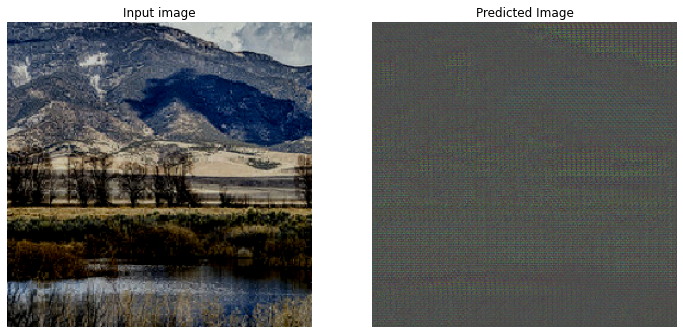

In [13]:
model = Model()
sample = next(iter(PHOTO_DS))
model.train_image(sample, model.generator_g)

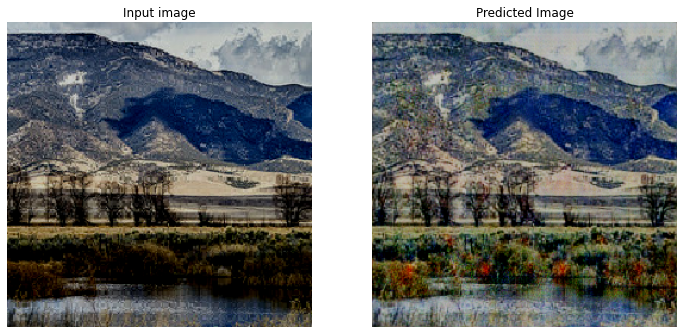

Time for epoch 100 is : 56.75897979736328


In [14]:
model.train(PHOTO_DS, MONET_DS)

<Figure size 1080x1080 with 0 Axes>

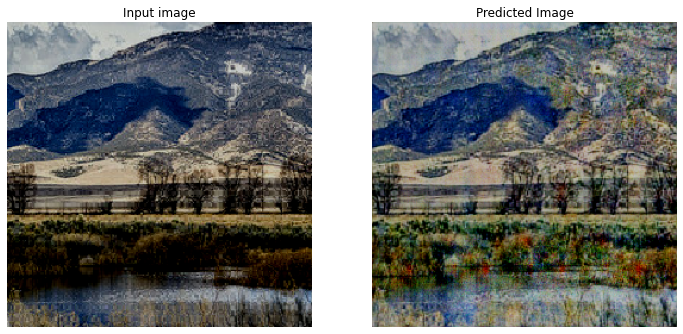

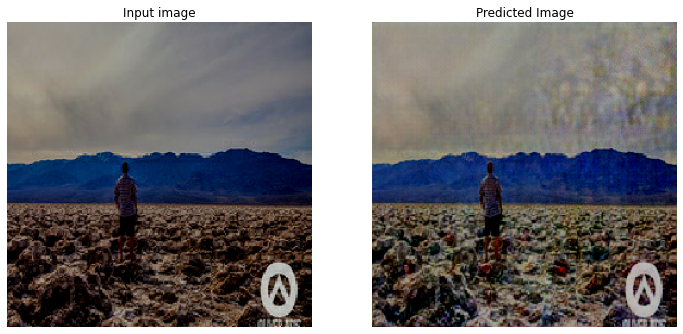

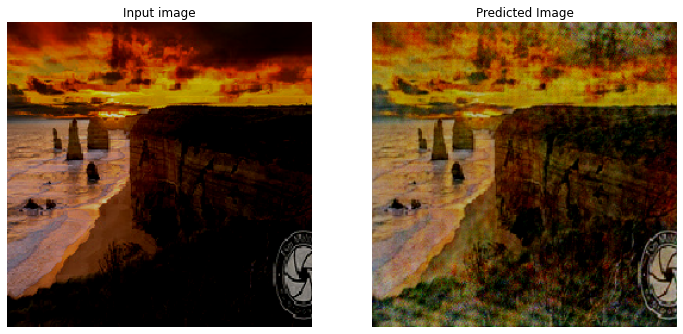

In [16]:
model.generate_images(PHOTO_DS, model.generator_g)